<a href="https://colab.research.google.com/github/hyd3nekosuki/RPDsummer2024/blob/main/1DSlabNodalDiff2024RPDsmr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from numba import njit

In [6]:
@njit(cache=True)
def calcFluxNodalDiffusion(SigA, D, L, H, a, b, c, x, albedo):
    A = np.zeros((2,2))
    y = np.zeros(2)

    expm = np.exp(-H/(2*L))
    expp = np.exp(+H/(2*L))
    A[0,0] = ( (1-albedo[0]) -2*(1+albedo[0])*(D/L) )*expm
    A[0,1] = ( (1-albedo[0]) +2*(1+albedo[0])*(D/L) )*expp
    A[1,0] = ( (1-albedo[1]) +2*(1+albedo[1])*(D/L) )*expp
    A[1,1] = ( (1-albedo[1]) -2*(1+albedo[1])*(D/L) )*expm
    y[0] = -(1-albedo[0])*(a*H*H/4 -b*H/2 +2*a*L*L+c)/SigA +2*(1+albedo[0])*L*L*(-a*H +b)
    y[1] = -(1-albedo[1])*(a*H*H/4 +b*H/2 +2*a*L*L+c)/SigA -2*(1+albedo[1])*L*L*(+a*H +b)

    coef = np.linalg.solve(A, y)
    flux = coef[0]*np.exp(x/L) + coef[1]*np.exp(-x/L) +(a*x*x +b*x +2*a*L*L +c)/SigA
    return flux

In [7]:
def ordinal(i):
    j = i%100
    return "{}".format(i)+({1:"st", 2:"nd", 3:"rd"}.get(j if 14>j>10 else j % 10) or "th")

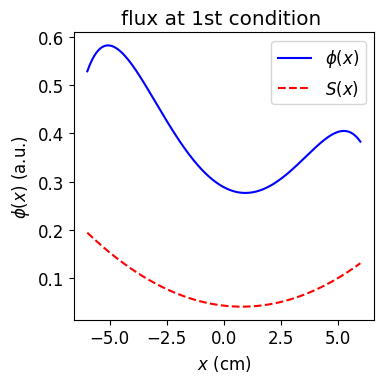

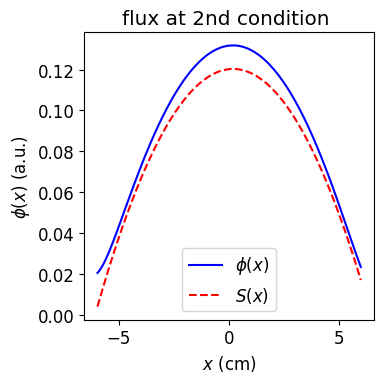

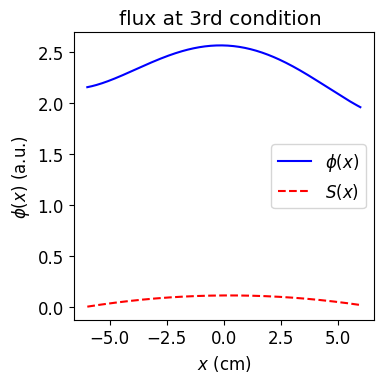

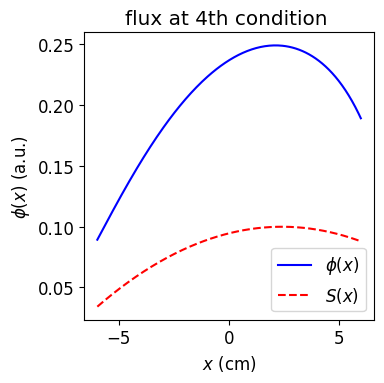

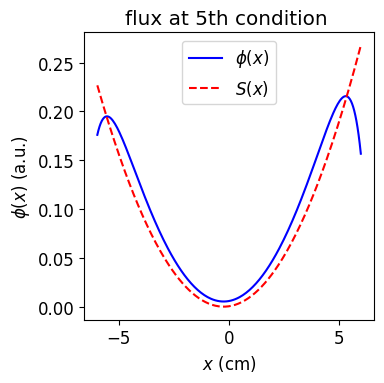

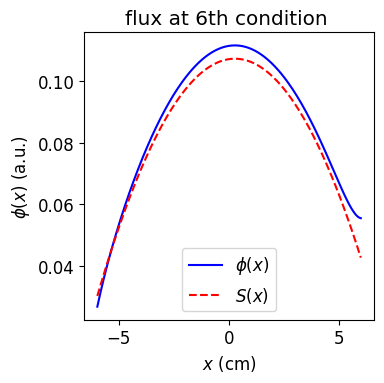

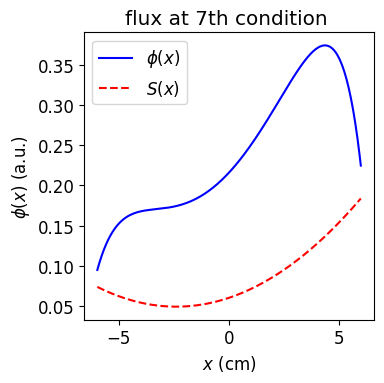

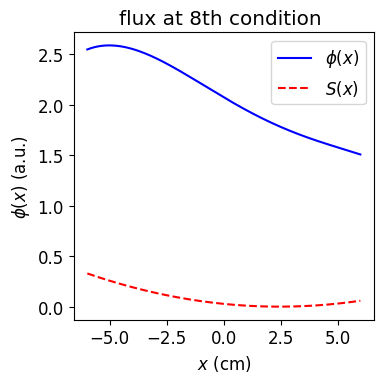

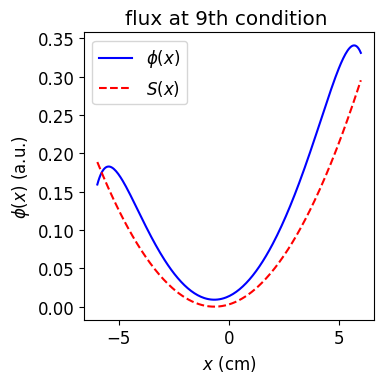

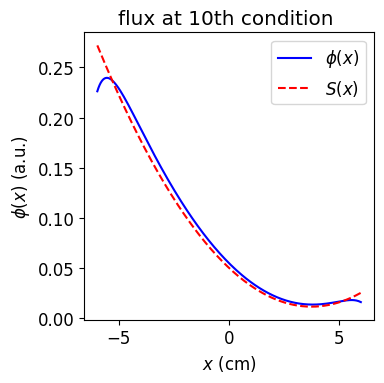

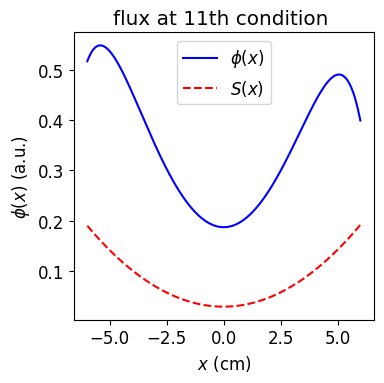

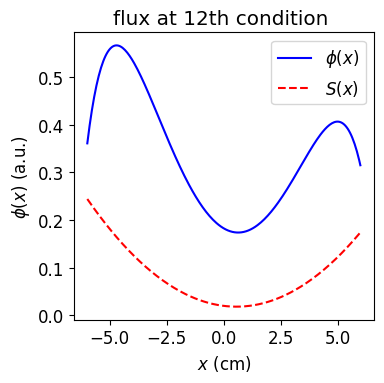

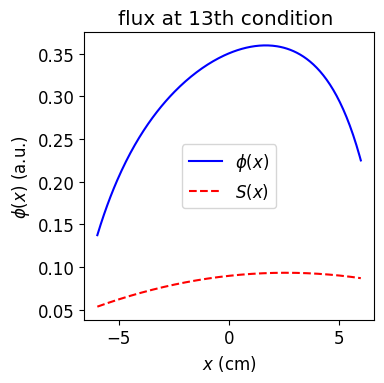

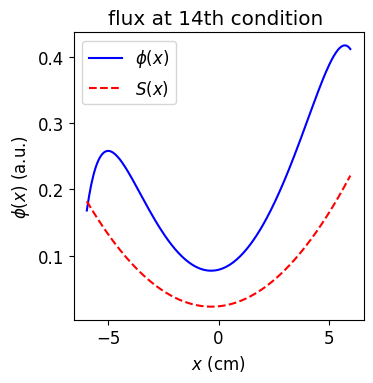

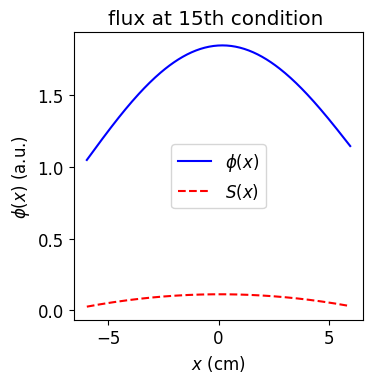

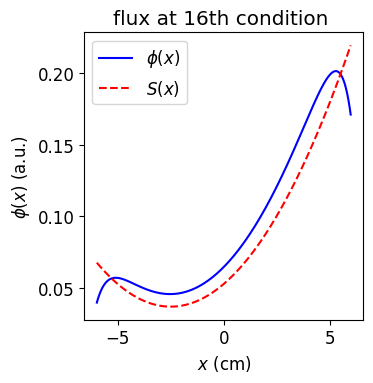

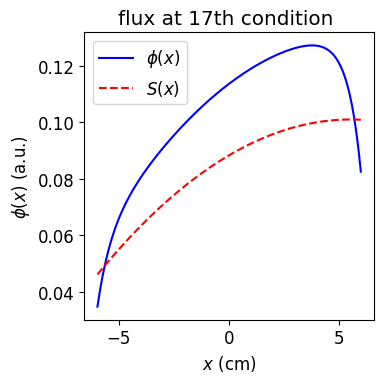

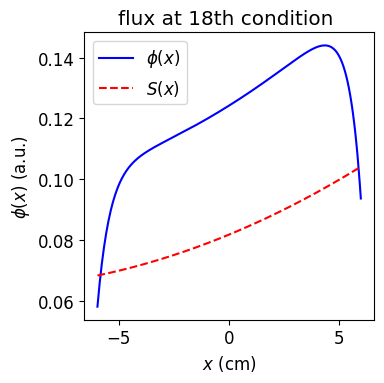

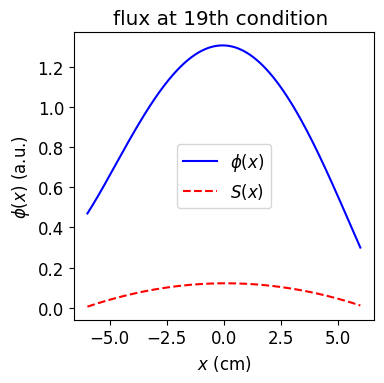

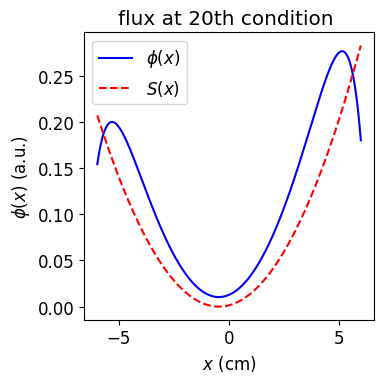

In [8]:
np.random.seed(20240619)

LengthX = 12.0
NX = 240
dx = np.full( NX, LengthX/NX )
xS = np.linspace(start=-LengthX/2, stop=LengthX/2, num=NX+1)
x = (xS[:-1] + xS[1:])/2

matid = np.zeros(NX, dtype=np.int64)
NC = 20
snapshotF = np.zeros( (NX,NC) )
snapshotQ = np.zeros( (NX,NC) )

plt.rcParams["figure.figsize"]=(4,4)
plt.rcParams["font.size"] = 12

for i in range(NC):
    SigA = np.random.uniform(low=0.01, high=1.0)
    SigS = np.random.uniform(low=0.01, high=1.0)

    s = np.zeros(NX)
    xi = np.random.uniform(low=-1.0, high=1.0)
    y = np.random.uniform(low=0.0, high=1.0, size=3)
    a = y[0]/(2*(1+xi)) +y[1]/(xi*xi-1) + y[2]/(2*(1-xi))
    b = (y[2]-y[0])/2
    c = xi*( y[0]/(2*(1+xi)) -y[2]/(2*(1-xi)) )  -y[1]/(xi*xi-1)
    vx = -b/(2*a)
    if vx>=-1 and vx<=1:
        vy = a*vx**2 + b*vx + c
        if vy <0:
            c = c-vy
            vy = vy = a*vx**2 + b*vx + c
            c = c-vy
    stotal = ((a/3)+c)*LengthX
    a = a/stotal
    b = b/stotal
    c = c/stotal

    SigT = SigA+SigS
    D = 1/(3*SigT)
    L = np.sqrt(D/SigA)

    a = 4*a/(LengthX* LengthX)
    b = 2*b/LengthX

    s = a*(x**2) + b*x + c
    if s.min() < 0:
        print("Warning: source is negative")

    albedo = np.random.uniform(low=0.0, high=1.0, size=(2))
    flux = calcFluxNodalDiffusion(SigA, D, L, LengthX, a, b, c, x, albedo)
    snapshotF[:,i] = flux
    snapshotQ[:,i] = (s + SigS*flux)

    #if i>= 10:
    #    continue

    plt.plot(x, flux, color="blue", linestyle="solid", label="$\phi(x)$")
    plt.plot(x, s, color="red", linestyle="dashed", label="$S(x)$")
    plt.title("flux at {} condition ".format(ordinal(i+1)))
    fluxmax = flux.max()
    #plt.ylim((0, fluxmax*1.1))
    plt.xlabel("$x$ (cm)")
    plt.ylabel("$\phi(x)$ (a.u.)")
    plt.legend()
    plt.tight_layout()
    plt.show()
